## Preliminaries
Import required Python packages.
We will use sklearn, a popular machine learning library to build a prediction model.

In [67]:
import os
import logging
import pandas as pd
import math
import numpy as np
import sklearn
# check correlation
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
# for plotting result (works with pandas)
import matplotlib.pyplot as plt
# for pretty formatting of results
from tabulate import tabulate
# random forest classifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from settings import Config

def random_forest_classifier(features, target):
    clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

def split_dataset(dataset, train_percentage, feature_headers, target_header):
    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y



## Load the Open Targets data
We load the Open Targets scores for the association between genes and diseases.

We also load the gene features that we will encode as integer to build the prediction model.

In [2]:
# load all the associations between gene and diseases from Open Targets
HOME_DIR = os.environ['HOME']
output_datatype_scores=os.path.join(os.path.sep, HOME_DIR, 'gene_disease_associations_datatypes_with_expression.csv')
df = pd.read_csv(output_datatype_scores)
print(len(df))

# load gene info
gene_info=os.path.join(os.path.sep, HOME_DIR, 'gene_info_qtq.csv')
gene_df = pd.read_csv(gene_info)


2304670


## First look at the data
In the following, we look at the top five rows, summary statistics and score distribution of the Open Targets dataset.
The first column of the data frame called `target_indication` is the key for the association between a gene and a disease (also called indication because some drugs are indicated for specific disease conditions).


In [3]:
# View the top 5 rows
df.head()

,target_indication,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,somatic_mutation,known_drug,rna_expression,affected_pathway,animal_model,literature,tissue_label,source,max_fold_change,expression_score
0,ENSG00000167113-Orphanet_183616,51117.0,ENSG00000167113,COQ4,Orphanet_183616,Genetic neuro-ophthalmological disease,eye disease; genetic disorder,False,1.000000,1.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,Unspecified,Unspecified,0.0,0.0
1,ENSG00000173085-EFO_0000249,27235.0,ENSG00000173085,COQ2,EFO_0000249,Alzheimers disease,nervous system disease,True,0.014184,0.000000,0.0,0.0,0.0,0.0,0.00000,0.014184,Unspecified,Unspecified,0.0,0.0
2,ENSG00000198612-EFO_0004512,10920.0,ENSG00000198612,COPS8,EFO_0004512,bone measurement,measurement,False,0.024117,0.024117,0.0,0.0,0.0,0.0,0.00000,0.000000,Unspecified,Unspecified,0.0,0.0
3,ENSG00000181789-Orphanet_101987,22820.0,ENSG00000181789,COPG1,Orphanet_101987,Constitutional neutropenia,immune system disease; genetic disorder,False,0.144740,0.000000,0.0,0.0,0.0,0.0,0.14474,0.000000,Unspecified,Unspecified,0.0,0.0
4,ENSG00000119723-Orphanet_50,51004.0,ENSG00000119723,COQ6,Orphanet_50,Aicardi syndrome,eye disease; genetic disorder,True,0.115500,0.000000,0.0,0.0,0.0,0.0,0.11550,0.000000,Unspecified,Unspecified,0.0,0.0


In [4]:
# look at the data (statistics)
print df.describe()

          entrez_id  overall_score  genetic_association  somatic_mutation  \
count  2.274296e+06   2.304670e+06         2.304670e+06      2.304670e+06   
mean   3.329095e+05   1.757477e-01         6.405781e-02      1.879467e-02   
std    5.438774e+06   2.931799e-01         2.405700e-01      1.068896e-01   
min    1.000000e+00   1.420000e-08         0.000000e+00      0.000000e+00   
25%    2.957000e+03   1.623600e-02         0.000000e+00      0.000000e+00   
50%    6.926000e+03   4.430408e-02         0.000000e+00      0.000000e+00   
75%    5.105300e+04   1.830850e-01         0.000000e+00      0.000000e+00   
max    1.097035e+08   1.557799e+00         1.494100e+00      1.273360e+00   

         known_drug  rna_expression  affected_pathway  animal_model  \
count  2.304670e+06    2.304670e+06      2.304670e+06  2.304670e+06   
mean   2.510575e-02    2.497605e-04      2.650752e-02  2.955334e-02   
std    1.409206e-01    2.181420e-03      1.279416e-01  6.667824e-02   
min    0.000000e+00   

## Plot the distribution of Open Targets scores across datatypes

### For all associations
The first treillis shows the distribution of scores for direct and indirect associations

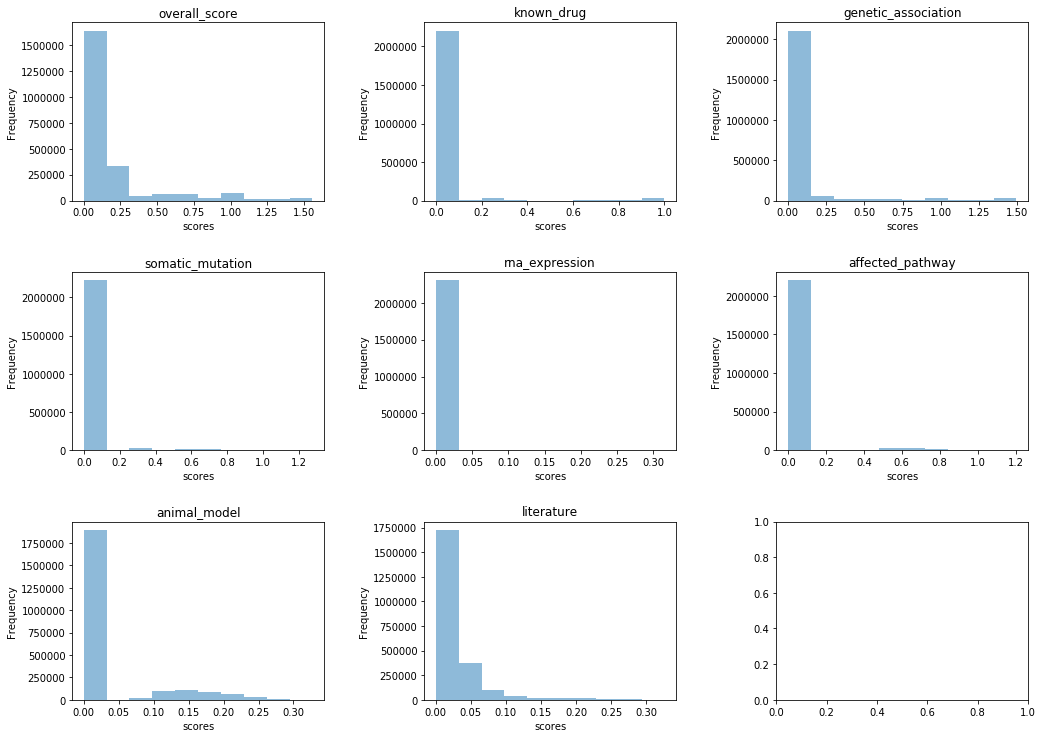

In [121]:
series = ['overall_score', 'known_drug','genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'literature']
ncols = 3
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,10))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust( wspace = 0.4, hspace = 0.4 )
for index, item in enumerate(series):
    posx = int(index/nrows)
    posy = index % ncols
    df[item].plot.hist(alpha=0.5, ax=axes[posx,posy], title=item)
    axes[posx,posy].set(xlabel="scores", ylabel="Frequency")

### For direct associations only
This second treillis shows only the distribution of scores for direct associations

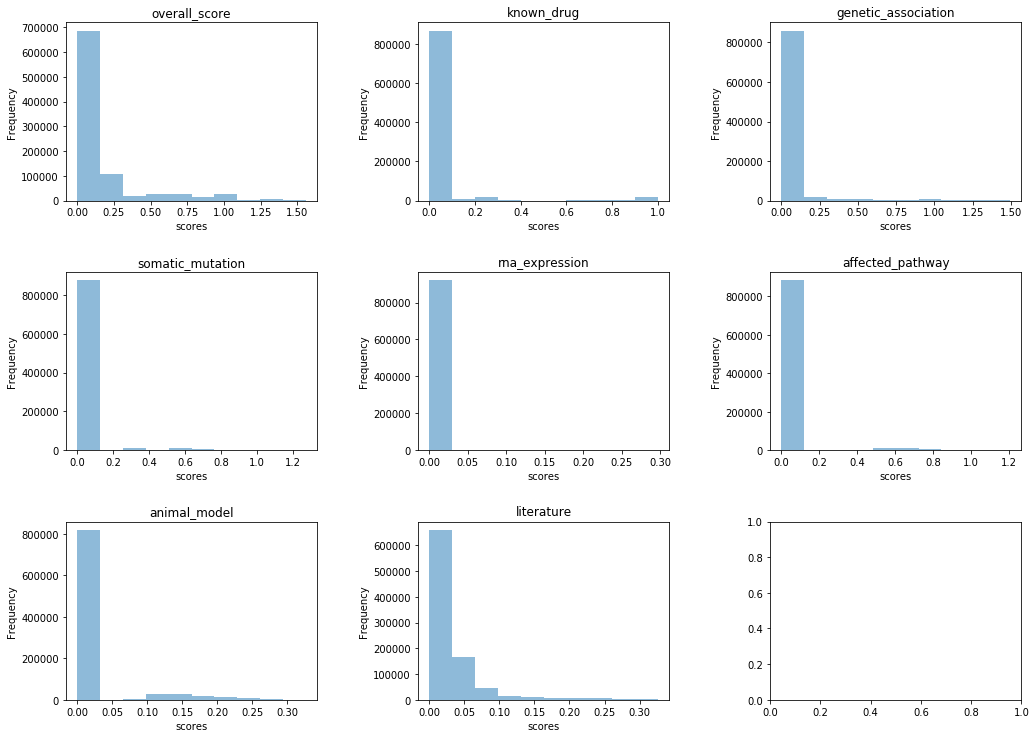

In [122]:
series = ['overall_score', 'known_drug','genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'literature']
ncols = 3
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,10))
fig.tight_layout()
plt.subplots_adjust( wspace = 0.4, hspace = 0.4 )
for index, item in enumerate(series):
    posx = int(index/nrows)
    posy = index % ncols
    df[df['is_direct']][item].plot.hist(alpha=0.5, ax=axes[posx,posy], title=item)
    axes[posx,posy].set(xlabel="scores", ylabel="Frequency")

### Example on how to select the rows with genetic and know_drug associations

In [5]:
# Look at the associations with genetic evidence
cond1 = \
    (df['genetic_association'] > 0.0) & \
    (df['known_drug'] > 0.0) & \
    (df['is_direct']) & \
    (df['overall_score'] > 0.8) & \
    (df['therapeutic_area'] == 'nervous system disease') & \
    (df['disease_label'] == 'Alzheimers disease')
df[cond1].head()

,target_indication,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,somatic_mutation,known_drug,rna_expression,affected_pathway,animal_model,literature,tissue_label,source,max_fold_change,expression_score
214196,ENSG00000157445-EFO_0000249,55799.0,ENSG00000157445,CACNA2D3,EFO_0000249,Alzheimers disease,nervous system disease,True,1.063939,0.246955,0.0,1.0,0.0,0.0,0.0,0.019800,Unspecified,Unspecified,0.0,0.0
233166,ENSG00000006283-EFO_0000249,8913.0,ENSG00000006283,CACNA1G,EFO_0000249,Alzheimers disease,nervous system disease,True,1.005908,0.023634,0.0,1.0,0.0,0.0,0.0,0.000000,Unspecified,Unspecified,0.0,0.0
259518,ENSG00000114200-EFO_0000249,590.0,ENSG00000114200,BCHE,EFO_0000249,Alzheimers disease,nervous system disease,True,1.033307,0.027835,0.0,1.0,0.0,0.0,0.0,0.120858,Unspecified,Unspecified,0.0,0.0
287000,ENSG00000141837-EFO_0000249,773.0,ENSG00000141837,CACNA1A,EFO_0000249,Alzheimers disease,nervous system disease,True,1.250000,1.000000,0.0,1.0,0.0,0.0,0.0,0.000000,Unspecified,Unspecified,0.0,0.0
429991,ENSG00000185313-EFO_0000249,6336.0,ENSG00000185313,SCN10A,EFO_0000249,Alzheimers disease,nervous system disease,True,1.000115,0.000460,0.0,1.0,0.0,0.0,0.0,0.000000,Unspecified,Unspecified,0.0,0.0


## Binning the data

After looking at the distribution of the known_drug score, we will bin these scores into 3 bins:
* low (score<=0.3)
* medium (0.3<score<=0.7)
* high (score>0.7)


In [123]:
# df.groupby(pd.cut(df['percentage'], bins=bins)).size()
b=df['known_drug'].values
print(type(b))
pd.cut(b, 4, labels=["verylow", "low", "medium", "high"])[:10]
# custom bucket area for drugs
bins = np.array([ -0.0, 0.3, 0.7, 2.0 ])
labels = [1,2,3]
df['known_drug_binned'] = np.searchsorted(bins, df['known_drug'].values)
print(df.groupby(np.searchsorted(bins, df['known_drug'].values)).size())
# that's an alternative way to do it
#df['known_drug_binned2'] = pd.cut(df['known_drug'], bins=bins, labels=False)
#print(pd.cut(df['known_drug'], bins=bins, labels=False))
#print(df.groupby(pd.cut(df['known_drug'], bins=bins)).size())
#categories = df['known_drug_binned'].cat.categories
#print(categories)

<type 'numpy.ndarray'>
0    2200186
1      51679
2       7169
3      45636
dtype: int64


## Filtering the data

We then filter the data to exclude any association that were propagated based on the disease classification.
We keep the association with the value `is_direct==True` and with a drug score > 0.
`known_drug_binned` will be the variable we want to predict.

54235


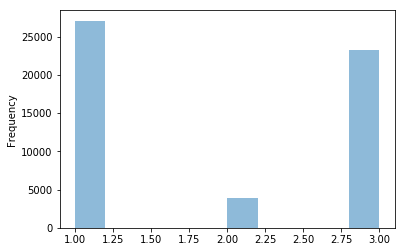

In [124]:
# get the data where is_direct is true and where there is some DRUG information ('known_drug')

cond1 = (df['known_drug'] > 0.0) & (df['is_direct'])
df_known_drug = df[cond1]

# 54,235
print(len(df_known_drug))
# plot distribution of series
df_known_drug['known_drug_binned'].plot.hist(alpha=0.5)

## Add gene features

In [89]:
gene_features = ['protein_class', 'locus_group', 'target_class', 'topology_type', 'target_location']
gene_feature_default_value = dict(
    protein_class = 'Unclassified protein',
    locus_group='other', 
    target_class='Other',
    topology_type='Unknown', 
    target_location='Unknown'
)

# check a few entries with some GO 
gene_df.fillna({x:gene_feature_default_value[x] for x in gene_features}, inplace=True)

gene_df[gene_df['go_id'].notnull() & gene_df['protein_class'].notnull() & gene_df['GTEX_median_all_tissues'] > 0.0].head()

,Unnamed: 0,symbol,hgnc_id,ensembl_gene_id,entrez_id,uniprot_id,locus_type,locus_group,go_id,go_label,evidence_type,reported_count,protein_class,target_class,topology_type,target_location,ExAC_LoF,pc_mouse_gene_identity,GTEX_median_all_tissues,description
60,60,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0006968,cellular defense response,TAS,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
61,61,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0046961,"proton-transporting ATPase activity, rotationa...",IBA,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
62,62,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0016236,macroautophagy,ISS,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
63,63,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0101003,ficolin-1-rich granule membrane,TAS,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
64,64,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0000220,"vacuolar proton-transporting V-type ATPase, V0...",IEA,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."


## Subselect the features we need to build the prediction model

In [90]:
# subselect the features we need for the training
gene_features = ['locus_group', 'target_class', 'topology_type', 'target_location']
gene_feature_map = dict()

series = ['ensembl_gene_id']
series.extend(gene_features)
print(series)

# subselect and drop duplicates
gene_pred_df = gene_df[series].drop_duplicates()
print(len(gene_pred_df))

['ensembl_gene_id', 'locus_group', 'target_class', 'topology_type', 'target_location']
36788


In [91]:
# remove duplicates (we keep only one label per feature for any gene)
# there might be some genes with contradictory information
# e.g. RNVU1-8, RNA, variant U1 small nuclear 8 (ENSG00000201142)
for gene_feature in gene_features:
    column_name = gene_feature
    group = gene_pred_df.groupby('ensembl_gene_id')[column_name].unique()
    r = group[group.apply(lambda x: len(x)>1)]
    for ensembl_gene_id, v in r.items():
        mask = gene_pred_df.ensembl_gene_id == ensembl_gene_id
        gene_pred_df.loc[mask, column_name] = v[0]
    gene_pred_df = gene_pred_df.drop_duplicates()
    print(len(gene_pred_df))

36787
36785
36785
36776


In [92]:
# get the distinct values of features as a list
for gene_feature in gene_features:
    l = gene_pred_df[gene_feature].drop_duplicates().tolist()
    gene_feature_map[gene_feature] = l
    print l

['non-coding RNA', 'other', 'protein-coding gene', 'pseudogene', 'phenotype']
['Other', 'Extracellular_all_others', 'Transporter', 'Enzyme_all_others', 'Enzyme_Transferase', '7TM_all_others', 'Transcriptional_Factor_all_others', 'Extracellular Ligand', 'Protease', 'Receptor_all_others', 'Not Characterized', 'Kinase_Protein', 'Nuclear Receptor', 'Enzyme_Esterase', 'Ion Channel', '7TM_Group1']
['Unknown', 'Secreted', 'MultiTM', 'Unattached', 'Membrane', 'SingleTM']
['Unknown', 'Free', 'Exposed', 'Cytoplasm', 'Organelle', 'Mitochondrion', 'Nucleus']


In [93]:
# We add the gene features to the df_chembl dataframe
print(len(df_known_drug))
df_known_drug_features = pd.merge(df_known_drug, gene_pred_df, how='left', on=['ensembl_gene_id'])
print(len(df_known_drug_features))
df_known_drug_features.fillna({x:gene_feature_default_value[x] for x in gene_features}, inplace=True)
print(len(df_known_drug_features))
df_known_drug_features.head()

54235
54235
54235


,target_indication,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,...,tissue_label,source,max_fold_change,expression_score,known_drug_binned,binned,locus_group,target_class,topology_type,target_location
0,ENSG00000093010-EFO_0004699,1312.0,ENSG00000093010,COMT,EFO_0004699,gambling behaviour,biological process,True,0.200000,0.0,...,Unspecified,Unspecified,0.0,0.0,1,1,protein-coding gene,Enzyme_Transferase,Unattached,Mitochondrion
1,ENSG00000093010-EFO_0000621,1312.0,ENSG00000093010,COMT,EFO_0000621,neuroblastoma,neoplasm,True,0.110838,0.0,...,Unspecified,Unspecified,0.0,0.0,1,1,protein-coding gene,Enzyme_Transferase,Unattached,Mitochondrion
2,ENSG00000119535-EFO_0006475,1441.0,ENSG00000119535,CSF3R,EFO_0006475,plasma cell leukemia,hematological system disease; neoplasm,True,0.125000,0.0,...,Unspecified,Unspecified,0.0,0.0,1,1,protein-coding gene,Receptor_all_others,Membrane,Exposed
3,ENSG00000119535-EFO_0002690,1441.0,ENSG00000119535,CSF3R,EFO_0002690,systemic lupus erythematosus,immune system disease; skeletal system disease,True,0.263798,0.0,...,Unspecified,Unspecified,0.0,0.0,1,1,protein-coding gene,Receptor_all_others,Membrane,Exposed
4,ENSG00000100368-EFO_0000649,1439.0,ENSG00000100368,CSF2RB,EFO_0000649,periodontitis,head and neck disorder,True,0.104602,0.0,...,Unspecified,Unspecified,0.0,0.0,1,1,protein-coding gene,Receptor_all_others,SingleTM,Exposed


In [94]:
# now create a numerical representation corresponding to the feature label using the index of each feature in a list
encoded_gene_features = list()
for gene_feature in gene_features:
    encoded_feature = 'encoded_' + gene_feature
    encoded_gene_features.append(encoded_feature)
    print(encoded_feature)
    df_known_drug_features[encoded_feature] = df_known_drug_features[gene_feature].apply(lambda x: gene_feature_map[gene_feature].index(x))
print(len(df_known_drug_features))
df_known_drug_features.head()

encoded_locus_group
encoded_target_class
encoded_topology_type
encoded_target_location
54235


,target_indication,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,...,known_drug_binned,binned,locus_group,target_class,topology_type,target_location,encoded_locus_group,encoded_target_class,encoded_topology_type,encoded_target_location
0,ENSG00000093010-EFO_0004699,1312.0,ENSG00000093010,COMT,EFO_0004699,gambling behaviour,biological process,True,0.200000,0.0,...,1,1,protein-coding gene,Enzyme_Transferase,Unattached,Mitochondrion,2,4,3,5
1,ENSG00000093010-EFO_0000621,1312.0,ENSG00000093010,COMT,EFO_0000621,neuroblastoma,neoplasm,True,0.110838,0.0,...,1,1,protein-coding gene,Enzyme_Transferase,Unattached,Mitochondrion,2,4,3,5
2,ENSG00000119535-EFO_0006475,1441.0,ENSG00000119535,CSF3R,EFO_0006475,plasma cell leukemia,hematological system disease; neoplasm,True,0.125000,0.0,...,1,1,protein-coding gene,Receptor_all_others,Membrane,Exposed,2,9,4,2
3,ENSG00000119535-EFO_0002690,1441.0,ENSG00000119535,CSF3R,EFO_0002690,systemic lupus erythematosus,immune system disease; skeletal system disease,True,0.263798,0.0,...,1,1,protein-coding gene,Receptor_all_others,Membrane,Exposed,2,9,4,2
4,ENSG00000100368-EFO_0000649,1439.0,ENSG00000100368,CSF2RB,EFO_0000649,periodontitis,head and neck disorder,True,0.104602,0.0,...,1,1,protein-coding gene,Receptor_all_others,SingleTM,Exposed,2,9,5,2


## Select the therapeutic area of interest
In this example, we will train the model on 'immune system disease'.


In [133]:
# drop the overall score as we don't need it in this exercice
print(len(df_known_drug_features))
series = ['target_indication', 'genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'expression_score']
series.extend(encoded_gene_features)
series.append('known_drug_binned')
print(series)

# everything
df_general_pred = df_known_drug_features[series]
headers = list(df_general_pred.columns.values)

# Let's build a model for a TA
# neoplasm for Cancer Drugs
# respiratory system disease for Asthma
# immune system disease
# 
TA = 'immune system disease'
TA_pred_cond = (df_known_drug_features['therapeutic_area'].str.contains(TA, na=False)) | (df_known_drug_features['disease_label'] == TA)
df_TA_pred = df_known_drug_features[TA_pred_cond][series]
print(len(df_TA_pred))

# TODO: we can train a model for cancer and a model for immuno-inflammation for instance.
# we can also add information about the disease
# Look at the associations with genetic evidence
#cond1 = \
#    (df_chembl_pred['genetic_association'] > 0.0) & \
#    (df_chembl_pred['target_indication'].str.startswith('ENSG00000185313', na=False))
#df_chembl_pred[cond1].head()
df_chembl_pred = df_TA_pred

54235
['target_indication', 'genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'expression_score', 'encoded_locus_group', 'encoded_target_class', 'encoded_topology_type', 'encoded_target_location', 'known_drug_binned']
3384


In [134]:
# Split the data in train and tests (80:20)
print(headers[1:-1])
print(headers[-1])
train_x, test_x, train_y, test_y = split_dataset(df_chembl_pred, 0.8, headers[1:-1], headers[-1])

# Train and Test dataset size details
'''
print "Train_x Shape :: ", train_x.shape
print "Train_y Shape :: ", train_y.shape
print "Test_x Shape :: ", test_x.shape
print "Test_y Shape :: ", test_y.shape
'''

# Create random forest classifier instance
trained_model = random_forest_classifier(train_x, train_y)
print "Trained model :: ", trained_model

predictions = trained_model.predict(test_x)


['genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'expression_score', 'encoded_locus_group', 'encoded_target_class', 'encoded_topology_type', 'encoded_target_location']
known_drug_binned
Trained model ::  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [135]:
for i in xrange(0, 20):
    print "Actual outcome :: {} and Predicted outcome :: {}".format(list(test_y)[i], predictions[i])

print "Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x))
print "Test Accuracy  :: ", accuracy_score(test_y, predictions)

Actual outcome :: 2 and Predicted outcome :: 1
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 1 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 1 and Predicted outcome :: 1
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 1
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 3
Actual outcome :: 1 and Predicted outcome :: 2
Actual outcome :: 1 and Predicted outcome :: 3
Actual outcome :: 1 and Predicted outcome :: 3
Actual outcome :: 2 and Predicted outcome :: 3
Actual outcome :: 3 and Predicted outcome :: 1
Actual outcome :: 3 and Predicted outcome :: 1
Actual outcome :: 2 and Predicted outcome :: 1
Actual outcome :: 1 and Predicted outcome :: 1
Train Accuracy ::  0.651643886221
Test Accuracy  ::  0.61595

## Create a confusion matrix
The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a way of tabulating the number of misclassifications, i.e., the number of predicted classes which ended up in a wrong classification bin based on the true classes.

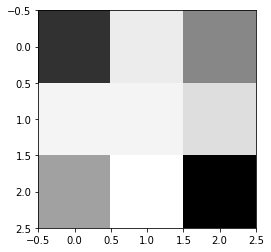

In [136]:
conf = confusion_matrix(test_y, predictions)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()

While sklearn.metrics.confusion_matrix provides a numeric matrix, it can be more useful to generate a 'report' using the following (https://stats.stackexchange.com/questions/95209/how-can-i-interpret-sklearn-confusion-matrix)

In [137]:
pd.crosstab(test_y, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,All
True,,,,
1,180,20,107,307
2,13,13,32,58
3,85,3,224,312
All,278,36,363,677


In [138]:
test_score = r2_score(test_y, predictions)
spearman = spearmanr(test_y, predictions)
pearson = pearsonr(test_y, predictions)
print('Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print('Test data R-2 score: {test_score:>5.3}')
print('Test data Spearman correlation: {spearman[0]:.3}')
print('Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}
Test data R-2 score: {test_score:>5.3}
Test data Spearman correlation: {spearman[0]:.3}
Test data Pearson correlation: {pearson[0]:.3}


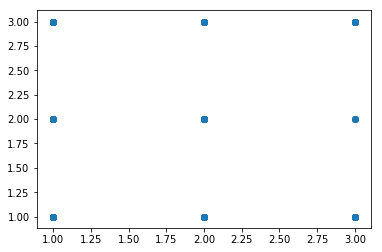

In [139]:
plt.scatter(test_y, predictions)
plt.show()

## How to inspect the importance of every feature in a random forest
With random forests we can get how important each feature was in classifying. In this case, we can see that `encoded_target_class` and `genetic_association` were more important in classification than (baseline and differential) RNA expression.

In [140]:
# inspect the importance of every feature in a random forest. 
headers = ["name", "score"]
values = sorted(zip(train_x.columns, trained_model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                          score
encoded_target_class     0.27389
genetic_association      0.179491
encoded_target_location  0.173071
rna_expression           0.154233
encoded_topology_type    0.10261
expression_score         0.0959498
animal_model             0.00963785
somatic_mutation         0.00878356
encoded_locus_group      0.0023333
affected_pathway         0
